In [18]:
import sys
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from feature_engineering import refuting_features, polarity_features, hand_features, gen_or_load_feats, gen_word2vec_feats
from feature_engineering import word_overlap_features
from feature_engineering import supporting_features, punctuation_features, question_features, cap_features
from feature_engineering import latent_semantic_indexing
from utils.dataset import DataSet
from utils.generate_test_splits import kfold_split, get_stances_for_folds
from utils.score import report_score, LABELS, score_submission
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
from sklearn.neural_network import MLPClassifier 
 
from utils.system import parse_params, check_version
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_features(stances,dataset,name):
    h, b, y = [],[],[]

    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])

    X_overlap = gen_or_load_feats(word_overlap_features, h, b, "features/overlap."+name+".npy")
    X_refuting = gen_or_load_feats(refuting_features, h, b, "features/refuting."+name+".npy")
    X_polarity = gen_or_load_feats(polarity_features, h, b, "features/polarity."+name+".npy")
    X_hand = gen_or_load_feats(hand_features, h, b, "features/hand."+name+".npy")
    
    X_supporting = gen_or_load_feats(supporting_features, h, b, "features/supporting."+name+".npy")
    X_punctuation = gen_or_load_feats(punctuation_features, h, b, "features/punctuation."+name+".npy")
    X_question = gen_or_load_feats(question_features, h, b, "features/question."+name+".npy")
    X_cap = gen_or_load_feats(cap_features, h, b, "features/cap."+name+".npy")

    X_lsi = gen_or_load_feats(latent_semantic_indexing, h, b, "features/lsi."+name+".npy")
    
    headVec, bodyVec, simVec = gen_word2vec_feats(h,b)
    X = np.c_[X_hand, X_polarity, X_refuting, X_overlap, X_supporting, X_punctuation, X_question, X_cap, X_lsi, headVec, bodyVec, simVec]
    #X = np.c_[X_hand, X_polarity, X_refuting, X_overlap, X_supporting, X_punctuation, X_question, X_cap, X_lsi]

    return X,y


In [3]:
check_version()

In [4]:
#Load the training dataset and generate folds
d = DataSet()
folds,hold_out= kfold_split(d,n_folds=10)
fold_stances, hold_out_stances = get_stances_for_folds(d,folds,hold_out)

# Load the competition dataset
competition_dataset = DataSet("competition_test")
X_competition, y_competition = generate_features(competition_dataset.stances, competition_dataset, "competition")



Reading dataset
Total stances: 49972
Total bodies: 1683
Reading dataset
Total stances: 25413
Total bodies: 904
generating word2vec features
model loaded


In [5]:
Xs = dict()
ys = dict()

# Load/Precompute all features now
X_holdout,y_holdout = generate_features(hold_out_stances,d,"holdout")
for fold in fold_stances:
    Xs[fold],ys[fold] = generate_features(fold_stances[fold],d,str(fold))


generating word2vec features
model loaded
generating word2vec features
model loaded
generating word2vec features
model loaded
generating word2vec features
model loaded
generating word2vec features
model loaded
generating word2vec features
model loaded
generating word2vec features
model loaded
generating word2vec features
model loaded
generating word2vec features
model loaded
generating word2vec features
model loaded
generating word2vec features
model loaded


# Building Individual Models

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [20]:
def apply_cv(model, parameters, fold_num):

    ids = list(range(len(folds)))
    del ids[fold_num]

    X_train = np.vstack(tuple([Xs[i] for i in ids]))
    y_train = np.hstack(tuple([ys[i] for i in ids]))

    X_test = Xs[fold_num]
    y_test = ys[fold_num]

    scoring = {'acc':'accuracy'}
    clf = GridSearchCV(model, parameters, cv=5, scoring=scoring, refit='acc')
    clf.fit(X_train, y_train)
    
    return clf

## Ridge Classifier

In [47]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV

param = {'alpha':[.1, 1, 10, 100], 'random_state':[42]}

m = RidgeClassifier()
r_results = apply_cv(m, param, 0)
print('best parameters: ' + str(r_results.best_params_))
print('best score: '+str(r_results.best_score_))

best parameters: {'alpha': 1, 'random_state': 42}
best score: 0.897301538375


## K-Means

In [48]:
from sklearn.cluster import KMeans

param = {'n_clusters':[4, 5, 6, 7, 8], 'random_state':[42]}

m = KMeans()
k_results = apply_cv(m, param, 0)
print('best parameters: ' + str(k_results.best_params_))
print('best score: '+str(k_results.best_score_))

best parameters: {'n_clusters': 4, 'random_state': 42}
best score: 0.244402723681


In [51]:
from sklearn.cluster import KMeans

param = {'n_clusters':[1, 2, 3], 'random_state':[42]}

m = KMeans()
k_2_results = apply_cv(m, param, 0)
print('best parameters: ' + str(k_2_results.best_params_))
print('best score: '+str(k_2_results.best_score_))

best parameters: {'n_clusters': 3, 'random_state': 42}
best score: 0.0853812312607


## Decision Trees

### DecisionTreeClassifier

In [50]:
from sklearn.tree import DecisionTreeClassifier

param = {'criterion':('gini', 'entropy'), 'max_depth':[5, 10, 20, None], 'random_state':[42]}

m = DecisionTreeClassifier()
d_results = apply_cv(m, param, 0)
print('best parameters: ' + str(d_results.best_params_))
print('best score: '+str(d_results.best_score_))

best parameters: {'criterion': 'gini', 'max_depth': 5, 'random_state': 42}
best score: 0.864096169473


### XGBoost

In [11]:
from xgboost import XGBClassifier 

param = {'n_estimators':[10, 50, 100, 200], 'max_depth': [2, 3, 5], 'seed':[42]}

m = XGBClassifier()
x_results = apply_cv(m, param, 0)
print('best parameters: ' + str(x_results.best_params_))
print('best score: '+str(x_results.best_score_))

best parameters: {'max_depth': 5, 'n_estimators': 200, 'seed': 42}
best score: 0.92193235632


## Multi-layer Perceptron

In [27]:
from sklearn.neural_network import MLPClassifier 

param = {'activation':('relu', 'tanh', 'logistic'), 'random_state':[42]}

m = MLPClassifier()
m_results = apply_cv(m, param, 0)
print('best parameters: ' + str(m_results.best_params_))
print('best score: '+str(m_results.best_score_))

best parameters: {'activation': 'logistic', 'random_state': 42}
best score: 0.918990108443


# Comparing tuned models

In [13]:
def model_score(model):
    res = []
    best_score = 0
    best_fold = None

    # Classifier for each fold
    for fold in [0, 1, 2]:
        ids = list(range(len(folds)))
        del ids[fold]

        X_train = np.vstack(tuple([Xs[i] for i in ids]))
        y_train = np.hstack(tuple([ys[i] for i in ids]))

        X_test = Xs[fold]
        y_test = ys[fold]

        clf = model
        clf.fit(X_train, y_train)

        predicted = [LABELS[int(a)] for a in clf.predict(X_test)]
        actual = [LABELS[int(a)] for a in y_test]

        fold_score, _ = score_submission(actual, predicted)
        max_fold_score, _ = score_submission(actual, actual)

        score = fold_score/max_fold_score

        print("Score for fold "+ str(fold) + " was - " + str(score))
        if score > best_score:
            best_score = score
            best_fold = clf

    res.append(best_fold)
            
    #Run on Holdout set and report the final score on the holdout set
    predicted = [LABELS[int(a)] for a in best_fold.predict(X_holdout)]
    actual = [LABELS[int(a)] for a in y_holdout]
    
    res.append(accuracy_score(actual, predicted))
    res.append(precision_score(actual, predicted, average='macro'))
    res.append(recall_score(actual,predicted, average='macro'))
    
    #Run on competition dataset
    predicted = [LABELS[int(a)] for a in best_fold.predict(X_competition)]
    actual = [LABELS[int(a)] for a in y_competition]
    
    res.append(accuracy_score(actual, predicted))
    res.append(precision_score(actual, predicted, average='macro'))
    res.append(recall_score(actual,predicted, average='macro'))

    print('done!')
    return res

In [8]:
ridge_c = model_score(RidgeClassifier(alpha=1, random_state=42))
kmeans_c = model_score(KMeans(n_clusters=4, random_state=42))

Score for fold 6 was - 0.8030738293593795
Score for fold 0 was - 0.845305221868105
Score for fold 7 was - 0.8277471361900721
Score for fold 5 was - 0.791899852724595
Score for fold 2 was - 0.8418144809537657
Score for fold 8 was - 0.8373333333333334
Score for fold 9 was - 0.8124476695506558
Score for fold 3 was - 0.834975037107003
Score for fold 1 was - 0.83056292778321
Score for fold 4 was - 0.8298755186721992


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


done!
Score for fold 6 was - 0.2997701809824763
Score for fold 0 was - 0.2712674675165482
Score for fold 7 was - 0.24423702446612927
Score for fold 5 was - 0.2948453608247423
Score for fold 2 was - 0.3498109915673161
Score for fold 8 was - 0.2673015873015873
Score for fold 9 was - 0.3371476416410829
Score for fold 3 was - 0.35258399676157065
Score for fold 1 was - 0.2660986171252968
Score for fold 4 was - 0.29431964515667475
done!


In [14]:
xgb_c = model_score(XGBClassifier(max_depth=5, n_estimators=200, seed=42))

Score for fold 0 was - 0.8746016180436381
Score for fold 1 was - 0.8807095963123341
Score for fold 2 was - 0.8694387903460308
done!


In [15]:
mlp_c = model_score(MLPClassifier(activation='logistic', random_state=42))

Score for fold 0 was - 0.8704339298847756
Score for fold 1 was - 0.8699539041765609
Score for fold 2 was - 0.8793253852864205
done!


In [34]:
ridge_c

[RidgeClassifier(alpha=1, class_weight=None, copy_X=True, fit_intercept=True,
         max_iter=None, normalize=False, random_state=42, solver='auto',
         tol=0.001),
 0.88702972355019749,
 0.57920530134908732,
 0.53577582462057427,
 0.86640695706921655,
 0.53703241288873871,
 0.51489075956426922]

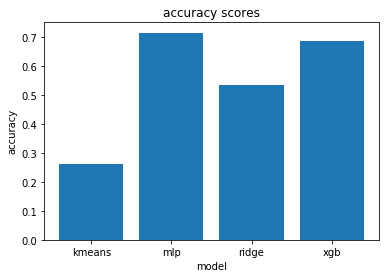

In [19]:
X_acc = ['ridge', 'kmeans', 'xgb','mlp']
Y_acc = [ridge_c[3], kmeans_c[3], xgb_c[3], mlp_c[3]]

plt.bar(X_acc, Y_acc)
plt.xlabel('model')
plt.ylabel('accuracy')
plt.title('accuracy scores')
plt.show()

In [ ]:
X_acc = ['ridge', 'kmeans', 'xgb','mlp']
Y_acc = [ridge_c[3], kmeans_c[3], xgb_c[3], mlp_c[3]]

plt.bar(X_acc, Y_acc)
plt.xlabel('model')
plt.ylabel('accuracy')
plt.title('accuracy scores')
plt.show()

## References
1. https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/